In [1]:
#pip install pyspark
#pip install hyperopt
#pip install mlflow

# Run these on your command line, to install xgboost
# conda install -c conda-forge xgboost
# conda install -c anaconda py-xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
import pipeline

## EDA

We will explore the data in this segment a little bit

In [3]:
universe=pd.read_csv('movie_universe_features.csv')
seed=pd.read_csv('seed.csv')

resp=pd.merge(seed, universe, 'left', 'User_ID')
resp['label']=1
size=resp.shape[0]
print(size)
# Balanced size of seed
non_resp=universe[~universe['User_ID'].isin(seed['User_ID'])].sample(size)
non_resp['label']=0

# Modelling data
modelinput = pd.concat([resp, non_resp], axis=0, ignore_index=True)

modelinput.groupby('label').count()['User_ID']

1500


label
0    1500
1    1500
Name: User_ID, dtype: int64

In [4]:
# Standardize data, dont change features
modelinput.head()

,User_ID,Feature_001,Feature_002,Feature_003,Feature_004,Feature_005,Feature_006,Feature_007,Feature_008,Feature_009,...,Feature_142,Feature_143,Feature_144,Feature_145,Feature_146,Feature_147,Feature_148,Feature_149,Feature_150,label
0,INT25666,9.444869,2.682099,2.057322,6.017722,6.357901,1.881625,12.845894,1.825739,1.486223,...,1.196316,5.519688,2.325635,1.294787,6.489395,2.360730,9.165950,1.211977,2.587949,1
1,INT16465,10.287428,6.492198,9.628861,4.854361,4.503690,2.991301,7.148927,1.470551,2.787417,...,0.349978,5.275994,10.263197,1.415012,8.472573,14.076540,3.929821,4.832758,8.317007,1
2,INT22387,2.923272,6.456325,7.007672,2.133051,4.445467,3.297151,6.040608,1.529596,1.186243,...,7.802857,8.765772,0.866869,2.587488,7.888250,4.252634,5.991852,0.142240,9.174461,1
3,INT10150,8.231396,0.087525,3.575617,0.865741,2.182167,0.503346,10.668799,5.275212,4.283442,...,8.343745,4.266352,0.339777,1.753501,1.666500,4.543080,8.246802,3.192204,9.528803,1
4,INT08730,9.905364,2.855321,8.284597,10.562502,10.378761,0.250803,8.007089,0.754002,1.473074,...,2.615259,0.386105,3.209463,12.272351,5.888321,5.958723,6.544291,5.486193,8.310601,1


In [5]:
if pd.isnull(modelinput['User_ID']).sum()==0:
    print('No missing IDs')
else:
    modelinput=modelinput[~pd.isnull(modelinput['User_ID'])]
    
modelinput.fillna(0, inplace=True)
modelinput.index=modelinput['User_ID']
modelinput.drop('User_ID', axis=1, inplace=True)
modelinput.label.count()

No missing IDs


3000

In [6]:
modelinput.head()

,Feature_001,Feature_002,Feature_003,Feature_004,Feature_005,Feature_006,Feature_007,Feature_008,Feature_009,Feature_010,...,Feature_142,Feature_143,Feature_144,Feature_145,Feature_146,Feature_147,Feature_148,Feature_149,Feature_150,label
User_ID,,,,,,,,,,,,,,,,,,,,,
INT25666,9.444869,2.682099,2.057322,6.017722,6.357901,1.881625,12.845894,1.825739,1.486223,0.340512,...,1.196316,5.519688,2.325635,1.294787,6.489395,2.360730,9.165950,1.211977,2.587949,1
INT16465,10.287428,6.492198,9.628861,4.854361,4.503690,2.991301,7.148927,1.470551,2.787417,5.699821,...,0.349978,5.275994,10.263197,1.415012,8.472573,14.076540,3.929821,4.832758,8.317007,1
INT22387,2.923272,6.456325,7.007672,2.133051,4.445467,3.297151,6.040608,1.529596,1.186243,0.011974,...,7.802857,8.765772,0.866869,2.587488,7.888250,4.252634,5.991852,0.142240,9.174461,1
INT10150,8.231396,0.087525,3.575617,0.865741,2.182167,0.503346,10.668799,5.275212,4.283442,0.752060,...,8.343745,4.266352,0.339777,1.753501,1.666500,4.543080,8.246802,3.192204,9.528803,1
INT08730,9.905364,2.855321,8.284597,10.562502,10.378761,0.250803,8.007089,0.754002,1.473074,9.009698,...,2.615259,0.386105,3.209463,12.272351,5.888321,5.958723,6.544291,5.486193,8.310601,1


In [7]:
X_train, X_test, y_train, y_test = train_test_split(modelinput.drop(['label'], axis=1), 
                                                    modelinput['label'], test_size=0.2, random_state=1233)

print(X_train.shape[0], X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])

print("Train seed Responders: {}; Non Responders: {}".format(y_train.sum(), y_train.count()-y_train.sum()))

scaler=MinMaxScaler()

scaled_train=scaler.fit_transform(X_train)
scaled_test=scaler.transform(X_test)

print(scaled_train)

2400 150
600 150
Train seed Responders: 1202; Non Responders: 1198
[[0.18621218 0.43509598 0.13712095 ... 0.70377947 0.25677739 0.58961175]
 [0.81119926 0.92163317 0.75284876 ... 0.43776082 0.26337148 0.58518674]
 [0.40075337 0.49249411 0.31335571 ... 0.64570167 0.30439342 0.2068477 ]
 ...
 [0.24295279 0.31692381 0.30145457 ... 0.26463226 0.58161344 0.29439028]
 [0.32311457 0.43684413 0.58381901 ... 0.13070628 0.07327617 0.19315696]
 [0.43783858 0.42939965 0.05343589 ... 0.21985176 0.4005959  0.25051767]]


### Feature Selection happens here

In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
"""
We will be using Hyper Opt
Hyperopt uses a form of Bayesian optimization for parameter tuning that allows you to get the best parameters
for a given model. 
It can optimize a model with hundreds of parameters on a large scale.
"""

# set parameter list
n_estimators=[i for i in range(100,1100, 100)]
max_depth=[i for i in range(2,13,1)]

#create random grid
rf_param = {
    'n_estimators': n_estimators,
    'max_depth': max_depth
}

# initiate model
rf_clf=RandomForestClassifier()

# Do a Random search for parameters
rf_random = RandomizedSearchCV(estimator=rf_clf, param_distributions=rf_param, n_iter=30, cv=3, verbose=2, random_state=420, n_jobs=-1)

# Fit the model and show the best parameters
rf_random.fit(scaled_train, y_train)
print(rf_random.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.6min finished


{'n_estimators': 300, 'max_depth': 11}


In [9]:
# get the best trial
best_rf=rf_random.best_estimator_
print(best_rf)

y_pred_train=best_rf.predict(scaled_train)
y_pred_test=best_rf.predict(scaled_test)

# Print Random Forest Model metrics
print('Train set results')
print(classification_report(y_train, y_pred_train))
print('Training AUC is', roc_auc_score(y_train, y_pred_train))
print('Train set results')
print(classification_report(y_test, y_pred_test))
print('Test AUC is', roc_auc_score(y_test, y_pred_test))

RandomForestClassifier(max_depth=11, n_estimators=300)
Train set results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1198
           1       1.00      1.00      1.00      1202

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400

Training AUC is 1.0
Train set results
              precision    recall  f1-score   support

           0       0.53      0.56      0.55       302
           1       0.53      0.50      0.52       298

    accuracy                           0.53       600
   macro avg       0.53      0.53      0.53       600
weighted avg       0.53      0.53      0.53       600

Test AUC is 0.5314791768523046


As you saw above, the test score / AUC is around 50%, which means our model works the same way as any random selection for this process.
So it is not a good model.

In [10]:
# save feature importances

feature_importances = best_rf.feature_importances_  # list
rf_imp=pd.DataFrame(feature_importances)
rf_imp=rf_imp.rename(columns={0:'Feature Importance'})


feature_names=[i for i in X_train.columns if i not in ['User_ID', 'label']]
rf_fname=pd.DataFrame(feature_names)
rf_fname=rf_fname.rename(columns={0:'Feature Name'})


rf_feature_table=pd.concat([rf_fname, rf_imp], axis=1)

In [11]:
pd.set_option("display.max_rows", None)
rf_feature_table.sort_values(by='Feature Importance', ascending=False).head(200)

,Feature Name,Feature Importance
15,Feature_016,0.010864
108,Feature_109,0.010052
4,Feature_005,0.008966
98,Feature_099,0.008825
133,Feature_134,0.008712
68,Feature_069,0.008490
114,Feature_115,0.008450
67,Feature_068,0.008336
131,Feature_132,0.008173
96,Feature_097,0.008052


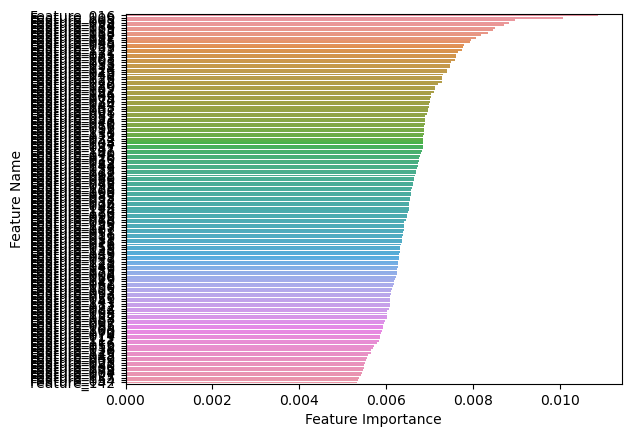

In [12]:
rf_feature_table_sorted=rf_feature_table.sort_values(by='Feature Importance', ascending=False)
sns.barplot(y=rf_feature_table_sorted['Feature Name'].iloc[:], 
            x=rf_feature_table_sorted['Feature Importance'].iloc[:], orient='h')

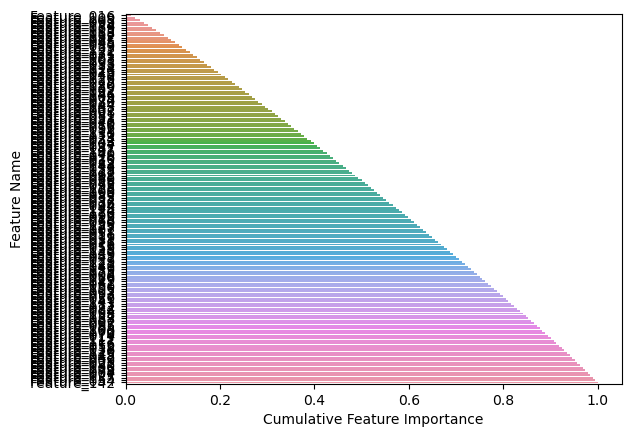

In [13]:
rf_feature_table_sorted['Cumulative Feature Importance']=rf_feature_table_sorted['Feature Importance'].cumsum()
sns.barplot(y=rf_feature_table_sorted['Feature Name'].iloc[:], 
            x=rf_feature_table_sorted['Cumulative Feature Importance'].iloc[:], orient='h')

In [14]:
#keep the 70% important features
print(rf_feature_table_sorted[rf_feature_table_sorted['Cumulative Feature Importance']<0.7].shape[0])
features_keep = rf_feature_table_sorted[rf_feature_table_sorted['Cumulative Feature Importance']<0.6]['Feature Name'].tolist()
features_list = [i for i in rf_feature_table['Feature Name'].tolist() if i in features_keep]
print(len(features_list))

99
83


In [15]:
# The above selected features will go for final estimator model
modelinput_gbm=modelinput[features_list+['label']]

print(modelinput_gbm.shape)
modelinput_gbm.head(5)

(3000, 84)


,Feature_001,Feature_003,Feature_005,Feature_008,Feature_010,Feature_013,Feature_015,Feature_016,Feature_018,Feature_020,...,Feature_133,Feature_134,Feature_136,Feature_140,Feature_143,Feature_144,Feature_146,Feature_147,Feature_148,label
User_ID,,,,,,,,,,,,,,,,,,,,,
INT25666,9.444869,2.057322,6.357901,1.825739,0.340512,0.622544,8.452012,5.598190,6.940051,2.275310,...,1.375561,8.765113,10.241662,1.252804,5.519688,2.325635,6.489395,2.360730,9.165950,1
INT16465,10.287428,9.628861,4.503690,1.470551,5.699821,2.726565,4.104565,7.764170,13.264170,5.102745,...,5.090492,4.898149,4.937917,3.440586,5.275994,10.263197,8.472573,14.076540,3.929821,1
INT22387,2.923272,7.007672,4.445467,1.529596,0.011974,3.265518,4.030118,3.722469,5.807145,1.644394,...,0.554804,8.336587,3.662598,0.905100,8.765772,0.866869,7.888250,4.252634,5.991852,1
INT10150,8.231396,3.575617,2.182167,5.275212,0.752060,2.268040,1.852677,4.024305,9.631675,2.130528,...,5.719532,5.318168,8.246666,1.802609,4.266352,0.339777,1.666500,4.543080,8.246802,1
INT08730,9.905364,8.284597,10.378761,0.754002,9.009698,0.462741,6.554926,8.781708,3.595659,6.700018,...,4.660071,2.627604,12.294739,1.045971,0.386105,3.209463,5.888321,5.958723,6.544291,1


In [16]:
X_train, X_test, y_train, y_test = train_test_split(modelinput_gbm.drop(['label'], axis=1), 
                                                    modelinput_gbm['label'], test_size=0.2, random_state=1233)

print(X_train.shape[0], X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])

print("Train seed Responders: {}; Non Responders: {}".format(y_train.sum(), y_train.count()-y_train.sum()))

scaler=MinMaxScaler()

scaled_train=scaler.fit_transform(X_train)
scaled_test=scaler.transform(X_test)

2400 83
600 83
Train seed Responders: 1202; Non Responders: 1198


In [17]:
# Save the scaler model, as well as the feature list
import pickle

with open("scalerModelObj.pkl", "wb") as f:
    pickle.dump(scaler, f)
    
with open("final_feature_list.pkl","wb") as f:
    pickle.dump(features_list, f)

In [19]:
#define model space
# Note: - keep running 'mlflow ui' command in anaconda prompt, for mlflow to work 
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
import pyspark
from sklearn.metrics import accuracy_score
import mlflow
from xgboost import XGBClassifier
from builtins import round, max, min, int

mlflow.autolog()
# set tracking uri, where mlflow saves runs
#mlflow.set_tracking_uri("file:///C:/Users/Ayush/Desktop/Books/Python%20with%20machine%20learning%20and%20data%20science%20bootcamp/mlflow")

# create an experiment
#experiment_id=mlflow.create_experiment("lal_gbt_train_exp1")
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("lal_gbt_train_exp1")
experiment_id=dict(mlflow.get_experiment_by_name("lal_gbt_train_exp1"))["experiment_id"]


feature_space_gbt = hp.choice('classifier_type',[
                          {
                                  'type':'gbt',
                                  'max_depth':hp.quniform('max_depth', 2, 13, 1),
                                  'n_estimators':hp.quniform('n_estimators', 50, 500, 50),
                                  'learning_rate':hp.quniform('learning_rate', 0.05, 0.95, 0.05),
                                  'subsample':hp.quniform('subsample', 0.1, 1, 0.1)
                          },

])

feature_space_xgb = hp.choice('classifier_type',[
                          {
                                  'type':'xgboost',
                                  'max_depth':hp.quniform('max_depth', 10, 30, 1),
                                  'n_estimators':hp.quniform('n_estimators', 1, 151, 10),
                                  'learning_rate':hp.quniform('learning_rate', 0.01, 0.99, 0.01),
                                  'subsample':hp.quniform('subsample', 0.2, 1, 0.01)
                          },

])

def minmization_fn_gbt(params):
    classifier_type=params['type']
    del params['type']
    if classifier_type=='gbt':
        # Initialise GBT
        clf=GradientBoostingClassifier(n_estimators=int(params['n_estimators']),learning_rate=params['learning_rate'],
                                       max_depth=int(params['max_depth']), subsample=params['subsample'])
    else:
        return 0
    
    with mlflow.start_run(nested=True):
        mlflow.log_param("learning_rate", params['learning_rate'])
        mlflow.log_param("n_estimators", params['learning_rate'])
        mlflow.log_param("max_depth", params['max_depth'])
        mlflow.log_param("subsample", params['subsample'])
    
    gbt_model=clf.fit(scaled_train, y_train)
    y_train_pred = gbt_model.predict(scaled_train)
    y_test_pred = gbt_model.predict(scaled_test)
    train_auc=roc_auc_score(y_train, y_train_pred)
    test_auc=roc_auc_score(y_test, y_test_pred)
    
    print("Training AUC is: %f"% (train_auc))
    print("Test AUC is: %f"% (test_auc))
    
    with mlflow.start_run(nested=True): 
        mlflow.log_metric("test_auc", test_auc)
        mlflow.log_metric("train_auc", train_auc)
        #log models
        mlflow.sklearn.log_model(clf, 'model')
    
    # Since fmin will minimize the objective loss, this function should return negative accuracy
    return {'loss':-test_auc, 'status':STATUS_OK, 'Train_AUC':train_auc, 'Test_AUC':test_auc,
            'important_features':gbt_model.feature_importances_,
           'model':gbt_model}

def minmization_fn_xgb(params):
    classifier_type=params['type']
    del params['type']
    if classifier_type=='xgboost':
        # Initialise GBT
        clf=XGBClassifier(n_estimators=int(params['n_estimators']),learning_rate=params['learning_rate'],
                                       max_depth=int(params['max_depth']), subsample=params['subsample'])
    else:
        return 0
    
    with mlflow.start_run(nested=True):
        mlflow.log_param("learning_rate", params['learning_rate'])
        mlflow.log_param("n_estimators", params['learning_rate'])
        mlflow.log_param("max_depth", params['max_depth'])
        mlflow.log_param("subsample", params['subsample'])
    
    xgb_model=clf.fit(scaled_train, y_train)
    y_train_pred = xgb_model.predict(scaled_train)
    y_test_pred = xgb_model.predict(scaled_test)
    train_auc=roc_auc_score(y_train, y_train_pred)
    test_auc=roc_auc_score(y_test, y_test_pred)
    test_acc=accuracy_score(y_test, y_test_pred)
    train_acc=accuracy_score(y_train, y_train_pred)
    
    print("Training AUC is: %f"% (train_auc))
    print("Test AUC is: %f"% (test_auc))
    
    print("Training accuracy is: %f"% (train_acc))
    print("Test accuracy is: %f"% (test_acc))
    
    with mlflow.start_run(nested=True):
        mlflow.log_metric("test_auc", test_auc)
        mlflow.log_metric("train_auc", train_auc)
    loss=-test_acc
    
    # Since fmin will minimize the objective loss, this function should return negative accuracy
    return {'loss':loss, 'status':STATUS_OK, 'Train_AUC':train_auc, 'Test_AUC':test_auc,
            'important_features':xgb_model.feature_importances_,
           'model':xgb_model}


2023/05/06 14:39:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/05/06 14:39:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/05/06 14:39:37 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2023/05/06 14:39:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/05/06 14:39:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2023/05/06 14:39:37 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pyspark.ml. If you encounter errors during autologging, try upgrading / downgrading pyspark.ml to a supported version, or try upgrading MLflow.
2023/05/06 14:39:37 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the 

In [20]:
trials = Trials()
mlflow.end_run()
best=None

mlflow.end_run()

# Launch the search
with mlflow.start_run(experiment_id=experiment_id):
    with mlflow.start_run(nested=True):
        #log run tags 
        mlflow.set_tag('some_tag', 'Parallelized HyperOpt')
    best = fmin(
            fn=minmization_fn_xgb,
            space=feature_space_xgb,
            algo=tpe.suggest,
            trials=trials,
            max_evals=100
    )
        


  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:40:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

2023/05/06 14:40:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Ayush\Anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


Training AUC is: 1.000000                                                                                              
Test AUC is: 0.536824                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.536667                                                                                             
[14:40:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  1%|▍                                              | 1/100 [00:13<21:38, 13.12s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:41:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.505167                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.505000                                                                                             
[14:41:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  2%|▉                                            | 2/100 [01:18<1:11:48, 43.96s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:42:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.510089                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.510000                                                                                             
[14:42:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  3%|█▎                                           | 3/100 [02:24<1:27:21, 54.04s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:43:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.997501                                                                                              
Test AUC is: 0.514856                                                                                                  
Training accuracy is: 0.997500                                                                                         
Test accuracy is: 0.515000                                                                                             
[14:43:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  4%|█▊                                           | 4/100 [03:31<1:34:34, 59.10s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:44:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.481655                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.481667                                                                                             
[14:44:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  5%|██▎                                          | 5/100 [04:38<1:37:31, 61.60s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:45:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.748747                                                                                              
Test AUC is: 0.518345                                                                                                  
Training accuracy is: 0.748750                                                                                         
Test accuracy is: 0.518333                                                                                             
[14:45:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  6%|██▋                                          | 6/100 [05:43<1:38:40, 62.99s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:46:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.520112                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.520000                                                                                             
[14:46:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  7%|███▏                                         | 7/100 [06:50<1:39:45, 64.36s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:47:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.770815                                                                                              
Test AUC is: 0.496978                                                                                                  
Training accuracy is: 0.770833                                                                                         
Test accuracy is: 0.496667                                                                                             
[14:47:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  8%|███▌                                         | 8/100 [07:56<1:39:34, 64.95s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:48:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.479866                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.480000                                                                                             
[14:49:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  9%|████                                         | 9/100 [09:02<1:38:45, 65.11s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:50:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.501545                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.501667                                                                                             
[14:50:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 10%|████▍                                       | 10/100 [10:08<1:37:54, 65.27s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:51:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.521879                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.521667                                                                                             
[14:51:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 11%|████▊                                       | 11/100 [11:13<1:36:57, 65.36s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:52:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.911270                                                                                              
Test AUC is: 0.500089                                                                                                  
Training accuracy is: 0.911250                                                                                         
Test accuracy is: 0.500000                                                                                             
[14:52:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 12%|█████▎                                      | 12/100 [12:19<1:35:56, 65.41s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:53:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.461832                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.461667                                                                                             
[14:53:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 13%|█████▋                                      | 13/100 [13:24<1:34:51, 65.42s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:54:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.515256                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.515000                                                                                             
[14:54:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 14%|██████▏                                     | 14/100 [14:30<1:33:51, 65.49s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:55:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.997088                                                                                              
Test AUC is: 0.516690                                                                                                  
Training accuracy is: 0.997083                                                                                         
Test accuracy is: 0.516667                                                                                             
[14:55:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 15%|██████▌                                     | 15/100 [15:35<1:32:48, 65.51s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:56:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.503245                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.503333                                                                                             
[14:56:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 16%|███████                                     | 16/100 [16:41<1:31:41, 65.50s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:57:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.999583                                                                                              
Test AUC is: 0.525079                                                                                                  
Training accuracy is: 0.999583                                                                                         
Test accuracy is: 0.525000                                                                                             
[14:57:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 17%|███████▍                                    | 17/100 [17:46<1:30:35, 65.49s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:58:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.528301                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.528333                                                                                             
[14:58:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 18%|███████▉                                    | 18/100 [18:52<1:29:25, 65.43s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 14:59:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.510045                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.510000                                                                                             
[14:59:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 19%|████████▎                                   | 19/100 [19:57<1:28:18, 65.41s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:00:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.486555                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.486667                                                                                             
[15:01:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 20%|████████▊                                   | 20/100 [21:03<1:27:19, 65.49s/trial, best loss: -0.5366666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:02:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.541746                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.541667                                                                                             
[15:02:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 21%|█████████▏                                  | 21/100 [22:08<1:26:19, 65.56s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:03:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.508345                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.508333                                                                                             
 22%|█████████▋                                  | 22/100 [23:14<1:25:13, 65.56s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:03:15 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\Ayush\Anaconda3\lib\site-packages\mlflow\xgboost\__init__.py", line 636, in train
    features, importance = zip(*imp.items())
ValueError: not enough values to unpack (expected 2, got 0)
2023/05/06 15:04:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while 

Training AUC is: 0.500000                                                                                              
Test AUC is: 0.500000                                                                                                  
Training accuracy is: 0.499167                                                                                         
Test accuracy is: 0.503333                                                                                             
[15:04:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 23%|██████████                                  | 23/100 [24:19<1:24:05, 65.52s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:05:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.498278                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.498333                                                                                             
[15:05:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 24%|██████████▌                                 | 24/100 [25:25<1:22:59, 65.52s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:06:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.498322                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.498333                                                                                             
[15:06:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 25%|███████████                                 | 25/100 [26:31<1:22:02, 65.63s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:07:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.997500                                                                                              
Test AUC is: 0.521634                                                                                                  
Training accuracy is: 0.997500                                                                                         
Test accuracy is: 0.521667                                                                                             
[15:07:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 26%|███████████▍                                | 26/100 [27:36<1:20:54, 65.60s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:08:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.495011                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.495000                                                                                             
[15:08:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 27%|███████████▉                                | 27/100 [28:42<1:19:45, 65.56s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:09:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.478410                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.478333                                                                                             
[15:09:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 28%|████████████▎                               | 28/100 [29:47<1:18:42, 65.58s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:10:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.488255                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.488333                                                                                             
[15:10:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 29%|████████████▊                               | 29/100 [30:53<1:17:42, 65.67s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:11:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.525212                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.525000                                                                                             
[15:12:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 30%|█████████████▏                              | 30/100 [31:59<1:16:33, 65.62s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:13:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.959574                                                                                              
Test AUC is: 0.510112                                                                                                  
Training accuracy is: 0.959583                                                                                         
Test accuracy is: 0.510000                                                                                             
[15:13:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 31%|█████████████▋                              | 31/100 [33:05<1:15:30, 65.66s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:14:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.511656                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.511667                                                                                             
[15:14:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 32%|██████████████                              | 32/100 [34:11<1:14:43, 65.93s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:15:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.526579                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.526667                                                                                             
[15:15:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 33%|██████████████▌                             | 33/100 [35:17<1:13:30, 65.83s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:16:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.520023                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.520000                                                                                             
[15:16:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 34%|██████████████▉                             | 34/100 [36:22<1:12:21, 65.79s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:17:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.483088                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.483333                                                                                             
[15:17:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 35%|███████████████▍                            | 35/100 [37:28<1:11:08, 65.67s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:18:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.963751                                                                                              
Test AUC is: 0.501633                                                                                                  
Training accuracy is: 0.963750                                                                                         
Test accuracy is: 0.501667                                                                                             
[15:18:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 36%|███████████████▊                            | 36/100 [38:34<1:10:22, 65.98s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:19:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.498344                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.498333                                                                                             
[15:19:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 37%|████████████████▎                           | 37/100 [39:44<1:10:25, 67.07s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:20:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.485366                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.485000                                                                                             
[15:20:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 38%|████████████████▋                           | 38/100 [40:49<1:08:44, 66.53s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:21:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.506734                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.506667                                                                                             
[15:21:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 39%|█████████████████▏                          | 39/100 [41:55<1:07:18, 66.20s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:22:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.501789                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.501667                                                                                             
[15:23:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 40%|█████████████████▌                          | 40/100 [43:00<1:05:54, 65.92s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:24:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.524879                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.525000                                                                                             
[15:24:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 41%|██████████████████                          | 41/100 [44:06<1:04:52, 65.97s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:25:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.524968                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.525000                                                                                             
[15:25:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 42%|██████████████████▍                         | 42/100 [45:12<1:03:38, 65.84s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:26:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.491655                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.491667                                                                                             
[15:26:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 43%|██████████████████▉                         | 43/100 [46:17<1:02:30, 65.80s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:27:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.503511                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.503333                                                                                             
[15:27:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 44%|███████████████████▎                        | 44/100 [47:23<1:01:16, 65.65s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:28:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.852898                                                                                              
Test AUC is: 0.531924                                                                                                  
Training accuracy is: 0.852917                                                                                         
Test accuracy is: 0.531667                                                                                             
[15:28:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 45%|███████████████████▊                        | 45/100 [48:28<1:00:06, 65.57s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:29:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.498211                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.498333                                                                                             
[15:29:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 46%|█████████████████████▏                        | 46/100 [49:33<58:58, 65.53s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:30:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.494922                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.495000                                                                                             
[15:30:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 47%|█████████████████████▌                        | 47/100 [50:39<58:00, 65.68s/trial, best loss: -0.5416666666666666]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:31:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.548635                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.548333                                                                                             
[15:31:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 48%|██████████████████████                        | 48/100 [51:45<56:49, 65.57s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:32:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.496911                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.496667                                                                                             
[15:32:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 49%|██████████████████████▌                       | 49/100 [52:50<55:40, 65.49s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:33:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.952064                                                                                              
Test AUC is: 0.498300                                                                                                  
Training accuracy is: 0.952083                                                                                         
Test accuracy is: 0.498333                                                                                             
[15:33:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 50%|███████████████████████                       | 50/100 [53:55<54:33, 65.46s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:34:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.496822                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.496667                                                                                             
[15:35:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 51%|███████████████████████▍                      | 51/100 [55:01<53:30, 65.51s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:36:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.541702                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.541667                                                                                             
[15:36:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 52%|███████████████████████▉                      | 52/100 [56:11<53:25, 66.78s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:37:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.533424                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.533333                                                                                             
[15:37:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 53%|████████████████████████▍                     | 53/100 [57:17<52:07, 66.55s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:38:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.998335                                                                                              
Test AUC is: 0.530201                                                                                                  
Training accuracy is: 0.998333                                                                                         
Test accuracy is: 0.530000                                                                                             
[15:38:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 54%|████████████████████████▊                     | 54/100 [58:22<50:46, 66.23s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:39:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.992083                                                                                              
Test AUC is: 0.513467                                                                                                  
Training accuracy is: 0.992083                                                                                         
Test accuracy is: 0.513333                                                                                             
[15:39:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 55%|█████████████████████████▎                    | 55/100 [59:28<49:29, 65.99s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:40:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.468565                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.468333                                                                                             
[15:40:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 56%|████████████████████████▋                   | 56/100 [1:00:33<48:15, 65.81s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:41:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.491633                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.491667                                                                                             
[15:41:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 57%|█████████████████████████                   | 57/100 [1:01:39<47:06, 65.74s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:42:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.503489                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.503333                                                                                             
[15:42:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 58%|█████████████████████████▌                  | 58/100 [1:02:44<45:58, 65.67s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:43:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.513156                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.513333                                                                                             
[15:43:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 59%|█████████████████████████▉                  | 59/100 [1:03:50<44:54, 65.73s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:44:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.511789                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.511667                                                                                             
[15:44:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 60%|██████████████████████████▍                 | 60/100 [1:04:55<43:43, 65.60s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:45:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.546669                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.546667                                                                                             
[15:46:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 61%|██████████████████████████▊                 | 61/100 [1:06:01<42:36, 65.54s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:47:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.494900                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.495000                                                                                             
[15:47:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 62%|███████████████████████████▎                | 62/100 [1:07:06<41:29, 65.50s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:48:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.514901                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.515000                                                                                             
[15:48:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 63%|███████████████████████████▋                | 63/100 [1:08:12<40:23, 65.51s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:49:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.996668                                                                                              
Test AUC is: 0.493533                                                                                                  
Training accuracy is: 0.996667                                                                                         
Test accuracy is: 0.493333                                                                                             
[15:49:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 64%|████████████████████████████▏               | 64/100 [1:09:17<39:17, 65.50s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:50:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.504856                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.505000                                                                                             
[15:50:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 65%|████████████████████████████▌               | 65/100 [1:10:23<38:11, 65.46s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:51:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.526757                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.526667                                                                                             
[15:51:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 66%|█████████████████████████████               | 66/100 [1:11:28<37:05, 65.45s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:52:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.490333                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.490000                                                                                             
[15:52:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 67%|█████████████████████████████▍              | 67/100 [1:12:33<35:59, 65.44s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:53:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.516601                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.516667                                                                                             
[15:53:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 68%|█████████████████████████████▉              | 68/100 [1:13:39<34:54, 65.44s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:54:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.530068                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.530000                                                                                             
[15:54:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 69%|██████████████████████████████▎             | 69/100 [1:14:45<33:49, 65.47s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:55:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.540068                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.540000                                                                                             
[15:55:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 70%|██████████████████████████████▊             | 70/100 [1:15:50<32:45, 65.52s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:56:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.513223                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.513333                                                                                             
[15:56:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 71%|███████████████████████████████▏            | 71/100 [1:16:56<31:41, 65.57s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:57:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.496778                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.496667                                                                                             
[15:58:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 72%|███████████████████████████████▋            | 72/100 [1:18:01<30:36, 65.59s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 15:59:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.997083                                                                                              
Test AUC is: 0.490288                                                                                                  
Training accuracy is: 0.997083                                                                                         
Test accuracy is: 0.490000                                                                                             
[15:59:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 73%|████████████████████████████████            | 73/100 [1:19:07<29:31, 65.63s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:00:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.525057                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.525000                                                                                             
[16:02:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 74%|███████████████████████████████▊           | 74/100 [1:22:14<44:11, 101.98s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:03:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.523379                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.523333                                                                                             
[16:08:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 75%|██████████████████████████████▊          | 75/100 [1:28:08<1:04:17, 154.29s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:09:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.519868                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.520000                                                                                             
 76%|███████████████████████████████▏         | 76/100 [1:32:23<1:23:08, 207.84s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[16:12:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 76%|███████████████████████████████▏         | 76/100 [1:32:23<1:23:08, 207.84s/trial, best loss: -0.5483333333333333]

2023/05/06 16:14:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2023/05/06 16:16:18 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Ayush\AppData\Local\Temp\tmpw9b30j2e\model, flavor: xgboost), fall back to return ['xgboost==1.5.0']. Set logging level to DEBUG to see the full traceback.


Training AUC is: 1.000000                                                                                              
Test AUC is: 0.460109                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.460000                                                                                             
[16:18:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 77%|███████████████████████████████▌         | 77/100 [1:38:24<1:31:12, 237.94s/trial, best loss: -0.5483333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:20:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.997919                                                                                              
Test AUC is: 0.550113                                                                                                  
Training accuracy is: 0.997917                                                                                         
Test accuracy is: 0.550000                                                                                             
[16:20:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 78%|██████████████████████████████████████████▉            | 78/100 [1:40:30<1:20:47, 220.35s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:21:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.947500                                                                                              
Test AUC is: 0.503245                                                                                                  
Training accuracy is: 0.947500                                                                                         
Test accuracy is: 0.503333                                                                                             
[16:21:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 79%|███████████████████████████████████████████▍           | 79/100 [1:41:36<1:00:51, 173.88s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:22:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.974165                                                                                              
Test AUC is: 0.483466                                                                                                  
Training accuracy is: 0.974167                                                                                         
Test accuracy is: 0.483333                                                                                             
[16:22:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 80%|█████████████████████████████████████████████▌           | 80/100 [1:42:41<47:07, 141.38s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:23:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.991668                                                                                              
Test AUC is: 0.500178                                                                                                  
Training accuracy is: 0.991667                                                                                         
Test accuracy is: 0.500000                                                                                             
[16:23:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 81%|██████████████████████████████████████████████▏          | 81/100 [1:43:47<37:33, 118.62s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:24:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.545102                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.545000                                                                                             
[16:24:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 82%|██████████████████████████████████████████████▋          | 82/100 [1:44:52<30:47, 102.66s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:25:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.683342                                                                                              
Test AUC is: 0.513134                                                                                                  
Training accuracy is: 0.683333                                                                                         
Test accuracy is: 0.513333                                                                                             
[16:25:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 83%|████████████████████████████████████████████████▏         | 83/100 [1:45:58<25:55, 91.50s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:26:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.972920                                                                                              
Test AUC is: 0.479999                                                                                                  
Training accuracy is: 0.972917                                                                                         
Test accuracy is: 0.480000                                                                                             
[16:27:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 84%|████████████████████████████████████████████████▋         | 84/100 [1:47:03<22:18, 83.66s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:28:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.987083                                                                                              
Test AUC is: 0.483266                                                                                                  
Training accuracy is: 0.987083                                                                                         
Test accuracy is: 0.483333                                                                                             
[16:28:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 85%|█████████████████████████████████████████████████▎        | 85/100 [1:48:08<19:32, 78.14s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:29:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.998333                                                                                              
Test AUC is: 0.544791                                                                                                  
Training accuracy is: 0.998333                                                                                         
Test accuracy is: 0.545000                                                                                             
[16:29:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 86%|█████████████████████████████████████████████████▉        | 86/100 [1:49:14<17:20, 74.30s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:30:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.777943                                                                                              
Test AUC is: 0.508456                                                                                                  
Training accuracy is: 0.777917                                                                                         
Test accuracy is: 0.508333                                                                                             
[16:30:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 87%|██████████████████████████████████████████████████▍       | 87/100 [1:50:19<15:31, 71.62s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:31:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.491766                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.491667                                                                                             
[16:31:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 88%|███████████████████████████████████████████████████       | 88/100 [1:51:25<13:57, 69.78s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:32:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.481766                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.481667                                                                                             
[16:32:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 89%|███████████████████████████████████████████████████▌      | 89/100 [1:52:31<12:34, 68.60s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:33:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.984583                                                                                              
Test AUC is: 0.520201                                                                                                  
Training accuracy is: 0.984583                                                                                         
Test accuracy is: 0.520000                                                                                             
[16:33:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 90%|████████████████████████████████████████████████████▏     | 90/100 [1:53:36<11:17, 67.70s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:34:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.483577                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.483333                                                                                             
 91%|████████████████████████████████████████████████████▊     | 91/100 [1:54:41<10:03, 67.06s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:34:43 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\Ayush\Anaconda3\lib\site-packages\mlflow\xgboost\__init__.py", line 636, in train
    features, importance = zip(*imp.items())
ValueError: not enough values to unpack (expected 2, got 0)
2023/05/06 16:35:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while 

Training AUC is: 0.500000                                                                                              
Test AUC is: 0.500000                                                                                                  
Training accuracy is: 0.499167                                                                                         
Test accuracy is: 0.503333                                                                                             
[16:35:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 92%|█████████████████████████████████████████████████████▎    | 92/100 [1:55:47<08:53, 66.63s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:36:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.510000                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.510000                                                                                             
[16:36:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 93%|█████████████████████████████████████████████████████▉    | 93/100 [1:56:53<07:43, 66.26s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:37:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.540313                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.540000                                                                                             
[16:40:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 94%|█████████████████████████████████████████████████████▌   | 94/100 [2:00:08<10:26, 104.45s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:41:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.942085                                                                                              
Test AUC is: 0.525212                                                                                                  
Training accuracy is: 0.942083                                                                                         
Test accuracy is: 0.525000                                                                                             
[16:41:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 95%|███████████████████████████████████████████████████████   | 95/100 [2:01:16<07:50, 94.11s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:42:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.501900                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.501667                                                                                             
[16:43:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 96%|██████████████████████████████████████████████████████▋  | 96/100 [2:03:25<06:58, 104.61s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:44:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.496822                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.496667                                                                                             
[16:44:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 97%|████████████████████████████████████████████████████████▎ | 97/100 [2:04:33<04:40, 93.49s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:45:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.999584                                                                                              
Test AUC is: 0.506667                                                                                                  
Training accuracy is: 0.999583                                                                                         
Test accuracy is: 0.506667                                                                                             
[16:45:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 98%|████████████████████████████████████████████████████████▊ | 98/100 [2:05:40<02:51, 85.62s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:46:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.500111                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.500000                                                                                             
[16:46:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 99%|█████████████████████████████████████████████████████████▍| 99/100 [2:06:47<01:19, 79.89s/trial, best loss: -0.55]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:47:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 598aca6afcea493582375404530c40da. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.986665                                                                                              
Test AUC is: 0.525057                                                                                                  
Training accuracy is: 0.986667                                                                                         
Test accuracy is: 0.525000                                                                                             
100%|█████████████████████████████████████████████████████████| 100/100 [2:07:52<00:00, 76.73s/trial, best loss: -0.55]


In [21]:
print("Best Run: {}".format(best))

Best Run: {'classifier_type': 0, 'learning_rate': 0.32, 'max_depth': 15.0, 'n_estimators': 70.0, 'subsample': 0.3}


In [22]:
best_model_gbt = trials.best_trial['result']['model']
print(best_model_gbt)
print("Best Model Metrics and Parameters are: {}".format(best))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.32, max_delta_step=0,
              max_depth=15, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=70, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.3,
              tree_method='exact', validate_parameters=1, verbosity=None)
Best Model Metrics and Parameters are: {'classifier_type': 0, 'learning_rate': 0.32, 'max_depth': 15.0, 'n_estimators': 70.0, 'subsample': 0.3}


In [23]:
# Save gbt model
with open("gbtModel.pkl", "wb") as f:
    pickle.dump(best_model_gbt, f)

In [24]:
# Model metrics
def clf_evaluation(model, X_actual, y_actual):
    y_pred=model.predict(X_actual)
    
    # Print Random Forest Model metrics
    print(classification_report(y_actual, y_pred))
    print('AUC score is', roc_auc_score(y_actual, y_pred))

print("\t","="*12+" Training Set"+"="*12)
clf_evaluation(best_model_gbt, scaled_train, y_train)
print("\t","="*12+" Test Set"+"="*12)
clf_evaluation(best_model_gbt, scaled_test, y_test)

	 ============ Training Set============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1198
           1       1.00      1.00      1.00      1202

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400

AUC score is 0.9979187442187339
	 ============ Test Set============
              precision    recall  f1-score   support

           0       0.56      0.53      0.54       302
           1       0.55      0.57      0.56       298

    accuracy                           0.55       600
   macro avg       0.55      0.55      0.55       600
weighted avg       0.55      0.55      0.55       600

AUC score is 0.5501133383705943


In [25]:
#get features
imp_features = best_model_gbt.feature_importances_
gbt_feature_imp = pd.DataFrame(imp_features)

gbt_feature_imp=gbt_feature_imp.rename(columns={0:'Feature Importance'})
gbt_feature_names=pd.DataFrame(features_list)
gbt_feature_names=gbt_feature_names.rename(columns={0:'Feature Name'})
gbt_feature_importance=pd.concat([gbt_feature_names, gbt_feature_imp], axis=1)
gbt_feature_importance=gbt_feature_importance.sort_values(by='Feature Importance', ascending=False)

Since the accuracy of gbt is not so good, we will retrain it again using xgboost and lesser features

In [26]:
top_features_gbt=gbt_feature_importance[:30]['Feature Name'].tolist()
new_features_list=[f for f in features_list if f in top_features_gbt]

modelinput_xgb = modelinput[new_features_list+['label']]
print(modelinput_xgb.shape)

X_train, X_test, y_train, y_test = train_test_split(modelinput_xgb.drop(['label'], axis=1), 
                                                    modelinput_xgb['label'], test_size=0.3, random_state=1233)

print(X_train.shape[0], X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])

print("Train seed Responders: {}; Non Responders: {}".format(y_train.sum(), y_train.count()-y_train.sum()))

scaler=MinMaxScaler()

scaled_train=scaler.fit_transform(X_train)
scaled_test=scaler.transform(X_test)

modelinput_xgb.head()

(3000, 31)
2100 30
900 30
Train seed Responders: 1056; Non Responders: 1044


,Feature_020,Feature_022,Feature_024,Feature_029,Feature_033,Feature_037,Feature_040,Feature_045,Feature_046,Feature_053,...,Feature_098,Feature_099,Feature_114,Feature_115,Feature_124,Feature_126,Feature_132,Feature_133,Feature_148,label
User_ID,,,,,,,,,,,,,,,,,,,,,
INT25666,2.275310,5.717779,0.699708,3.766486,1.644702,0.589319,2.389994,5.171867,0.192413,2.845417,...,1.327683,3.331128,9.919242,0.215096,4.434425,3.575505,7.589168,1.375561,9.165950,1
INT16465,5.102745,1.483328,4.799635,10.110183,1.992093,3.861800,8.046835,3.109428,7.017014,0.841681,...,0.669835,10.352973,4.205502,0.797404,3.156862,10.734502,2.041284,5.090492,3.929821,1
INT22387,1.644394,7.434647,4.454434,4.917835,2.322871,3.413896,0.465058,9.682595,8.957606,2.723355,...,0.121390,6.460395,0.977984,1.071582,3.865294,8.284223,9.788766,0.554804,5.991852,1
INT10150,2.130528,11.631759,5.949340,6.198519,1.621265,0.335832,0.811294,3.684588,6.771054,5.637880,...,6.055158,3.851346,2.365255,2.589257,3.917452,9.669703,7.325485,5.719532,8.246802,1
INT08730,6.700018,0.840431,6.198063,10.730696,2.292089,1.771471,4.198412,7.210886,4.866385,2.268747,...,1.819827,7.065220,3.797710,11.944679,4.824495,7.880906,5.343467,4.660071,6.544291,1


In [27]:
trials = Trials()
mlflow.end_run()
best=None

mlflow.end_run()

# Launch the search
with mlflow.start_run(experiment_id=experiment_id):
    with mlflow.start_run(nested=True):
        #log run tags 
        mlflow.set_tag('some_tag', 'Parallelized HyperOpt')
    best = fmin(
            fn=minmization_fn_xgb,
            space=feature_space_xgb,
            algo=tpe.suggest,
            trials=trials,
            max_evals=120
    )
        
print("Best Run: {}".format(best))

[16:47:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                          | 0/120 [00:00<?, ?trial/s, best loss=?]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Training AUC is: 1.000000                                                                                              
Test AUC is: 0.500207                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.500000                                                                                             
[16:48:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  1%|▌                                                             | 1/120 [00:06<12:58,  6.54s/trial, best loss: -0.5]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:49:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.887049                                                                                              
Test AUC is: 0.524567                                                                                                  
Training accuracy is: 0.887143                                                                                         
Test accuracy is: 0.524444                                                                                             
[16:49:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  2%|▊                                            | 2/120 [01:14<1:23:45, 42.59s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:50:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.491110                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.491111                                                                                             
[16:50:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  2%|█▏                                           | 3/120 [02:19<1:43:08, 52.89s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:51:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.973332                                                                                              
Test AUC is: 0.508476                                                                                                  
Training accuracy is: 0.973333                                                                                         
Test accuracy is: 0.508889                                                                                             
[16:51:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  3%|█▌                                           | 4/120 [03:24<1:51:37, 57.74s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:52:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.492413                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.492222                                                                                             
[16:52:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  4%|█▉                                           | 5/120 [04:30<1:55:49, 60.43s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:53:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.945212                                                                                              
Test AUC is: 0.508802                                                                                                  
Training accuracy is: 0.945238                                                                                         
Test accuracy is: 0.508889                                                                                             
[16:53:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  5%|██▎                                          | 6/120 [05:35<1:57:52, 62.04s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:54:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.972353                                                                                              
Test AUC is: 0.515618                                                                                                  
Training accuracy is: 0.972381                                                                                         
Test accuracy is: 0.515556                                                                                             
[16:54:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  6%|██▋                                          | 7/120 [06:40<1:58:43, 63.04s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:55:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.504682                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.504444                                                                                             
[16:55:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  7%|███                                          | 8/120 [07:46<1:59:32, 64.04s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:56:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.481271                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.481111                                                                                             
[16:56:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  8%|███▍                                         | 9/120 [08:52<1:59:31, 64.61s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:57:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.517870                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.517778                                                                                             
[16:57:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  8%|███▋                                        | 10/120 [09:57<1:58:49, 64.82s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:58:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.998569                                                                                              
Test AUC is: 0.496859                                                                                                  
Training accuracy is: 0.998571                                                                                         
Test accuracy is: 0.496667                                                                                             
[16:58:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  9%|████                                        | 11/120 [11:02<1:58:00, 64.96s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 16:59:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.726342                                                                                              
Test AUC is: 0.478367                                                                                                  
Training accuracy is: 0.726190                                                                                         
Test accuracy is: 0.478889                                                                                             
[17:00:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 10%|████▍                                       | 12/120 [12:10<1:58:28, 65.82s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:01:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.993817                                                                                              
Test AUC is: 0.487820                                                                                                  
Training accuracy is: 0.993810                                                                                         
Test accuracy is: 0.487778                                                                                             
[17:01:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 11%|████▊                                       | 13/120 [13:16<1:57:10, 65.70s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:02:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.999527                                                                                              
Test AUC is: 0.480856                                                                                                  
Training accuracy is: 0.999524                                                                                         
Test accuracy is: 0.481111                                                                                             
[17:02:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 12%|█████▏                                      | 14/120 [14:21<1:55:57, 65.63s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:03:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.990928                                                                                              
Test AUC is: 0.519974                                                                                                  
Training accuracy is: 0.990952                                                                                         
Test accuracy is: 0.520000                                                                                             
[17:03:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 12%|█████▌                                      | 15/120 [15:27<1:54:49, 65.62s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:04:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.507942                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.507778                                                                                             
 13%|█████▊                                      | 16/120 [16:33<1:54:22, 65.98s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:04:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 13%|█████▊                                      | 16/120 [16:34<1:54:22, 65.98s/trial, best loss: -0.5244444444444445]

2023/05/06 17:05:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]


Training AUC is: 1.000000                                                                                              
Test AUC is: 0.495436                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.495556                                                                                             
[17:05:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 14%|██████▏                                     | 17/120 [17:39<1:53:10, 65.92s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:06:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.478841                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.478889                                                                                             
[17:06:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 15%|██████▌                                     | 18/120 [18:45<1:52:00, 65.89s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:07:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.495495                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.495556                                                                                             
[17:07:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 16%|██████▉                                     | 19/120 [19:51<1:50:37, 65.72s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:08:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.498992                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.498889                                                                                             
[17:08:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 17%|███████▎                                    | 20/120 [20:57<1:49:40, 65.81s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:09:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.493806                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.494444                                                                                             
[17:10:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 18%|███████▋                                    | 21/120 [22:04<1:49:15, 66.22s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:11:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.689476                                                                                              
Test AUC is: 0.476262                                                                                                  
Training accuracy is: 0.689524                                                                                         
Test accuracy is: 0.476667                                                                                             
[17:11:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 18%|████████                                    | 22/120 [23:09<1:47:41, 65.93s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:12:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.481330                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.481111                                                                                             
[17:12:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 19%|████████▍                                   | 23/120 [24:14<1:46:16, 65.74s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:13:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.669584                                                                                              
Test AUC is: 0.490635                                                                                                  
Training accuracy is: 0.669524                                                                                         
Test accuracy is: 0.491111                                                                                             
[17:13:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 20%|████████▊                                   | 24/120 [25:20<1:44:59, 65.62s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:14:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.905194                                                                                              
Test AUC is: 0.502608                                                                                                  
Training accuracy is: 0.905238                                                                                         
Test accuracy is: 0.502222                                                                                             
[17:14:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 21%|█████████▏                                  | 25/120 [26:26<1:44:19, 65.89s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:15:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.482130                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.482222                                                                                             
[17:15:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 22%|█████████▌                                  | 26/120 [27:32<1:43:10, 65.86s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:16:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.962856                                                                                              
Test AUC is: 0.508802                                                                                                  
Training accuracy is: 0.962857                                                                                         
Test accuracy is: 0.508889                                                                                             
[17:16:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 22%|█████████▉                                  | 27/120 [28:38<1:42:01, 65.82s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:17:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.482367                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.482222                                                                                             
[17:17:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 23%|██████████▎                                 | 28/120 [29:43<1:40:53, 65.80s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:18:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.990470                                                                                              
Test AUC is: 0.496622                                                                                                  
Training accuracy is: 0.990476                                                                                         
Test accuracy is: 0.496667                                                                                             
[17:18:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 24%|██████████▋                                 | 29/120 [30:49<1:39:33, 65.64s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:19:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.483316                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.483333                                                                                             
[17:19:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 25%|███████████                                 | 30/120 [31:54<1:38:19, 65.55s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:20:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.764749                                                                                              
Test AUC is: 0.491613                                                                                                  
Training accuracy is: 0.764762                                                                                         
Test accuracy is: 0.491111                                                                                             
[17:20:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 26%|███████████▎                                | 31/120 [32:59<1:37:05, 65.45s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:21:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.476618                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.476667                                                                                             
[17:22:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 27%|███████████▋                                | 32/120 [34:05<1:35:55, 65.40s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:23:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.474218                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.474444                                                                                             
[17:23:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 28%|████████████                                | 33/120 [35:10<1:35:01, 65.53s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:24:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.480085                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.480000                                                                                             
[17:24:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 28%|████████████▍                               | 34/120 [36:16<1:34:03, 65.62s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:25:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.493332                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.493333                                                                                             
[17:25:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 29%|████████████▊                               | 35/120 [37:22<1:33:01, 65.67s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:26:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.491880                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.492222                                                                                             
[17:26:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 30%|█████████████▏                              | 36/120 [38:27<1:31:48, 65.58s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:27:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.467965                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.467778                                                                                             
[17:27:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 31%|█████████████▌                              | 37/120 [39:33<1:30:35, 65.49s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:28:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.509780                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.510000                                                                                             
[17:28:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 32%|█████████████▉                              | 38/120 [40:38<1:29:35, 65.56s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:29:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.493480                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.493333                                                                                             
[17:29:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 32%|██████████████▎                             | 39/120 [41:44<1:28:24, 65.49s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:30:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.862809                                                                                              
Test AUC is: 0.504297                                                                                                  
Training accuracy is: 0.862857                                                                                         
Test accuracy is: 0.504444                                                                                             
[17:30:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 33%|██████████████▋                             | 40/120 [42:49<1:27:16, 65.46s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:31:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.499881                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.500000                                                                                             
[17:31:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 34%|███████████████                             | 41/120 [43:54<1:26:08, 65.43s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:32:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.495673                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.495556                                                                                             
[17:32:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 35%|███████████████▍                            | 42/120 [45:00<1:25:03, 65.43s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:33:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.836729                                                                                              
Test AUC is: 0.494192                                                                                                  
Training accuracy is: 0.836667                                                                                         
Test accuracy is: 0.494444                                                                                             
[17:34:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 36%|███████████████▊                            | 43/120 [46:05<1:23:57, 65.42s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:35:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.999521                                                                                              
Test AUC is: 0.511943                                                                                                  
Training accuracy is: 0.999524                                                                                         
Test accuracy is: 0.512222                                                                                             
[17:35:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 37%|████████████████▏                           | 44/120 [47:11<1:22:51, 65.41s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:36:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.511232                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.511111                                                                                             
[17:36:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 38%|████████████████▌                           | 45/120 [48:16<1:21:46, 65.43s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:37:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.467609                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.467778                                                                                             
[17:37:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 38%|████████████████▊                           | 46/120 [49:22<1:20:40, 65.42s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:38:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.958567                                                                                              
Test AUC is: 0.487761                                                                                                  
Training accuracy is: 0.958571                                                                                         
Test accuracy is: 0.487778                                                                                             
 39%|█████████████████▏                          | 47/120 [50:27<1:19:34, 65.41s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:38:23 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\Ayush\Anaconda3\lib\site-packages\mlflow\xgboost\__init__.py", line 636, in train
    features, importance = zip(*imp.items())
ValueError: not enough values to unpack (expected 2, got 0)
2023/05/06 17:39:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while 

Training AUC is: 0.500000                                                                                              
Test AUC is: 0.500000                                                                                                  
Training accuracy is: 0.497143                                                                                         
Test accuracy is: 0.506667                                                                                             
[17:39:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 40%|█████████████████▌                          | 48/120 [51:32<1:18:27, 65.38s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:40:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.997148                                                                                              
Test AUC is: 0.480974                                                                                                  
Training accuracy is: 0.997143                                                                                         
Test accuracy is: 0.481111                                                                                             
[17:40:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 41%|█████████████████▉                          | 49/120 [52:37<1:17:20, 65.35s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:41:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.723300                                                                                              
Test AUC is: 0.519026                                                                                                  
Training accuracy is: 0.723333                                                                                         
Test accuracy is: 0.518889                                                                                             
[17:41:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 42%|██████████████████▎                         | 50/120 [53:43<1:16:13, 65.33s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:42:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.849987                                                                                              
Test AUC is: 0.498992                                                                                                  
Training accuracy is: 0.850000                                                                                         
Test accuracy is: 0.498889                                                                                             
[17:42:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 42%|██████████████████▋                         | 51/120 [54:48<1:15:06, 65.30s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:43:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.514432                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.514444                                                                                             
[17:43:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 43%|███████████████████                         | 52/120 [55:53<1:13:59, 65.28s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:44:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.468409                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.468889                                                                                             
[17:44:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 44%|███████████████████▍                        | 53/120 [56:58<1:12:51, 65.24s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:45:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.500059                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.500000                                                                                             
[17:46:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 45%|███████████████████▊                        | 54/120 [58:05<1:12:05, 65.53s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:47:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.996179                                                                                              
Test AUC is: 0.509957                                                                                                  
Training accuracy is: 0.996190                                                                                         
Test accuracy is: 0.510000                                                                                             
[17:47:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 46%|████████████████████▏                       | 55/120 [59:11<1:11:16, 65.80s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:48:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.522019                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.522222                                                                                             
[17:48:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 47%|███████████████████▌                      | 56/120 [1:00:17<1:10:09, 65.77s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:49:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.523234                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.523333                                                                                             
 48%|███████████████████▉                      | 57/120 [1:01:22<1:09:00, 65.72s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:49:18 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\Ayush\Anaconda3\lib\site-packages\mlflow\xgboost\__init__.py", line 636, in train
    features, importance = zip(*imp.items())
ValueError: not enough values to unpack (expected 2, got 0)
2023/05/06 17:50:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while 

Training AUC is: 0.500000                                                                                              
Test AUC is: 0.500000                                                                                                  
Training accuracy is: 0.497143                                                                                         
Test accuracy is: 0.506667                                                                                             
[17:50:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 48%|████████████████████▎                     | 58/120 [1:02:28<1:07:55, 65.74s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:51:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.498755                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.498889                                                                                             
[17:51:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 49%|████████████████████▋                     | 59/120 [1:03:34<1:06:48, 65.72s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:52:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.499467                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.500000                                                                                             
 50%|█████████████████████                     | 60/120 [1:04:40<1:05:49, 65.82s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:52:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 50%|█████████████████████                     | 60/120 [1:04:40<1:05:49, 65.82s/trial, best loss: -0.5244444444444445]

2023/05/06 17:53:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]


Training AUC is: 0.998095                                                                                              
Test AUC is: 0.505512                                                                                                  
Training accuracy is: 0.998095                                                                                         
Test accuracy is: 0.505556                                                                                             
[17:53:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 51%|█████████████████████▎                    | 61/120 [1:05:46<1:04:43, 65.83s/trial, best loss: -0.5244444444444445]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:54:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.999048                                                                                              
Test AUC is: 0.527590                                                                                                  
Training accuracy is: 0.999048                                                                                         
Test accuracy is: 0.527778                                                                                             
[17:54:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 52%|█████████████████████▋                    | 62/120 [1:06:51<1:03:33, 65.75s/trial, best loss: -0.5277777777777778]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:55:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.507646                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.507778                                                                                             
[17:55:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 52%|██████████████████████                    | 63/120 [1:07:57<1:02:25, 65.72s/trial, best loss: -0.5277777777777778]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:56:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.995722                                                                                              
Test AUC is: 0.483286                                                                                                  
Training accuracy is: 0.995714                                                                                         
Test accuracy is: 0.483333                                                                                             
[17:56:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 53%|██████████████████████▍                   | 64/120 [1:09:03<1:01:20, 65.72s/trial, best loss: -0.5277777777777778]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:57:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.502134                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.502222                                                                                             
[17:58:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 54%|██████████████████████▊                   | 65/120 [1:10:08<1:00:14, 65.72s/trial, best loss: -0.5277777777777778]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 17:59:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.504327                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.504444                                                                                             
[17:59:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 55%|████████████████████████▏                   | 66/120 [1:11:14<59:08, 65.72s/trial, best loss: -0.5277777777777778]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:00:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.998580                                                                                              
Test AUC is: 0.506520                                                                                                  
Training accuracy is: 0.998571                                                                                         
Test accuracy is: 0.506667                                                                                             
[18:00:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 56%|████████████████████████▌                   | 67/120 [1:12:20<58:01, 65.70s/trial, best loss: -0.5277777777777778]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:01:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.494369                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.494444                                                                                             
[18:01:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 57%|████████████████████████▉                   | 68/120 [1:13:26<56:57, 65.71s/trial, best loss: -0.5277777777777778]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:02:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.499141                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.498889                                                                                             
[18:02:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 57%|█████████████████████████▎                  | 69/120 [1:14:31<55:52, 65.73s/trial, best loss: -0.5277777777777778]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:03:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.497955                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.497778                                                                                             
[18:03:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 58%|█████████████████████████▋                  | 70/120 [1:15:37<54:47, 65.75s/trial, best loss: -0.5277777777777778]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:04:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.533399                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.533333                                                                                             
[18:04:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 59%|██████████████████████████                  | 71/120 [1:16:43<53:45, 65.82s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:05:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.524390                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.524444                                                                                             
[18:05:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 60%|██████████████████████████▍                 | 72/120 [1:17:49<52:37, 65.78s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:06:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.524508                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.524444                                                                                             
[18:06:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 61%|██████████████████████████▊                 | 73/120 [1:18:55<51:35, 65.86s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:07:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.514373                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.514444                                                                                             
[18:07:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 62%|███████████████████████████▏                | 74/120 [1:20:01<50:26, 65.80s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:08:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.498992                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.498889                                                                                             
[18:09:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 62%|███████████████████████████▌                | 75/120 [1:21:06<49:21, 65.80s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:10:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.500000                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.500000                                                                                             
[18:10:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 63%|███████████████████████████▊                | 76/120 [1:22:12<48:14, 65.79s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:11:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.491347                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.491111                                                                                             
[18:11:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 64%|████████████████████████████▏               | 77/120 [1:23:18<47:07, 65.76s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:12:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.496711                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.496667                                                                                             
[18:12:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 65%|████████████████████████████▌               | 78/120 [1:24:24<46:06, 65.88s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:13:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.494666                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.494444                                                                                             
[18:13:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 66%|████████████████████████████▉               | 79/120 [1:25:31<45:10, 66.11s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:14:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.999527                                                                                              
Test AUC is: 0.479107                                                                                                  
Training accuracy is: 0.999524                                                                                         
Test accuracy is: 0.478889                                                                                             
[18:14:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 67%|█████████████████████████████▎              | 80/120 [1:26:36<44:00, 66.00s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:15:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.521100                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.521111                                                                                             
[18:15:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 68%|█████████████████████████████▋              | 81/120 [1:27:42<42:49, 65.88s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:16:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.503438                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.503333                                                                                             
[18:16:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 68%|██████████████████████████████              | 82/120 [1:28:48<41:47, 65.99s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:17:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.481271                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.481111                                                                                             
[18:17:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 69%|██████████████████████████████▍             | 83/120 [1:29:54<40:38, 65.91s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:18:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.504297                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.504444                                                                                             
[18:18:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 70%|██████████████████████████████▊             | 84/120 [1:31:00<39:34, 65.95s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:19:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.999521                                                                                              
Test AUC is: 0.529931                                                                                                  
Training accuracy is: 0.999524                                                                                         
Test accuracy is: 0.530000                                                                                             
[18:20:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 71%|███████████████████████████████▏            | 85/120 [1:32:06<38:25, 65.87s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:21:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.519944                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.520000                                                                                             
[18:21:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 72%|███████████████████████████████▌            | 86/120 [1:33:11<37:18, 65.82s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:22:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.987123                                                                                              
Test AUC is: 0.525664                                                                                                  
Training accuracy is: 0.987143                                                                                         
Test accuracy is: 0.525556                                                                                             
[18:22:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 72%|███████████████████████████████▉            | 87/120 [1:34:17<36:11, 65.81s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:23:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.515440                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.515556                                                                                             
 73%|████████████████████████████████▎           | 88/120 [1:35:22<35:04, 65.78s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:23:19 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\Ayush\Anaconda3\lib\site-packages\mlflow\xgboost\__init__.py", line 636, in train
    features, importance = zip(*imp.items())
ValueError: not enough values to unpack (expected 2, got 0)
2023/05/06 18:24:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while 

Training AUC is: 0.500000                                                                                              
Test AUC is: 0.500000                                                                                                  
Training accuracy is: 0.497143                                                                                         
Test accuracy is: 0.506667                                                                                             
[18:24:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 74%|████████████████████████████████▋           | 89/120 [1:36:29<34:01, 65.87s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:25:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.893863                                                                                              
Test AUC is: 0.516625                                                                                                  
Training accuracy is: 0.893810                                                                                         
Test accuracy is: 0.516667                                                                                             
[18:25:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 75%|█████████████████████████████████           | 90/120 [1:37:35<33:01, 66.06s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:26:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.525634                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.525556                                                                                             
[18:26:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 76%|█████████████████████████████████▎          | 91/120 [1:38:41<31:53, 65.97s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:27:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.509454                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.510000                                                                                             
[18:27:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 77%|█████████████████████████████████▋          | 92/120 [1:39:47<30:45, 65.90s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:28:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.514551                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.514444                                                                                             
[18:28:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 78%|██████████████████████████████████          | 93/120 [1:40:52<29:37, 65.82s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:29:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.498874                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.498889                                                                                             
[18:29:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 78%|██████████████████████████████████▍         | 94/120 [1:41:58<28:30, 65.79s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:30:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.998090                                                                                              
Test AUC is: 0.499733                                                                                                  
Training accuracy is: 0.998095                                                                                         
Test accuracy is: 0.500000                                                                                             
[18:31:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 79%|██████████████████████████████████▊         | 95/120 [1:43:04<27:24, 65.78s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:32:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.510995                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.511111                                                                                             
[18:32:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 80%|███████████████████████████████████▏        | 96/120 [1:44:10<26:18, 65.77s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:33:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.517811                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.517778                                                                                             
[18:33:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 81%|███████████████████████████████████▌        | 97/120 [1:45:15<25:11, 65.73s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:34:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.498785                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.498889                                                                                             
[18:34:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 82%|███████████████████████████████████▉        | 98/120 [1:46:21<24:06, 65.74s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:35:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.515795                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.515556                                                                                             
[18:35:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 82%|████████████████████████████████████▎       | 99/120 [1:47:27<23:01, 65.80s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:36:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.490961                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.491111                                                                                             
[18:36:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 83%|███████████████████████████████████▊       | 100/120 [1:48:34<22:01, 66.07s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:37:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.496799                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.496667                                                                                             
 84%|████████████████████████████████████▏      | 101/120 [1:49:39<20:53, 65.98s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:37:35 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\Ayush\Anaconda3\lib\site-packages\mlflow\xgboost\__init__.py", line 636, in train
    features, importance = zip(*imp.items())
ValueError: not enough values to unpack (expected 2, got 0)
2023/05/06 18:38:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while 

Training AUC is: 0.500000                                                                                              
Test AUC is: 0.500000                                                                                                  
Training accuracy is: 0.497143                                                                                         
Test accuracy is: 0.506667                                                                                             
[18:38:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 85%|████████████████████████████████████▌      | 102/120 [1:50:45<19:47, 65.96s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:39:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.499881                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.500000                                                                                             
[18:39:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 86%|████████████████████████████████████▉      | 103/120 [1:51:51<18:40, 65.89s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:40:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.502252                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.502222                                                                                             
[18:40:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 87%|█████████████████████████████████████▎     | 104/120 [1:52:57<17:33, 65.87s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:41:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.494103                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.494444                                                                                             
[18:41:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 88%|█████████████████████████████████████▋     | 105/120 [1:54:03<16:27, 65.82s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:42:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.507290                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.507778                                                                                             
[18:43:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 88%|█████████████████████████████████████▉     | 106/120 [1:55:08<15:21, 65.81s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:44:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.999053                                                                                              
Test AUC is: 0.485449                                                                                                  
Training accuracy is: 0.999048                                                                                         
Test accuracy is: 0.485556                                                                                             
[18:44:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 89%|██████████████████████████████████████▎    | 107/120 [1:56:14<14:14, 65.77s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:45:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.497540                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.497778                                                                                             
[18:45:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 90%|██████████████████████████████████████▋    | 108/120 [1:57:20<13:09, 65.77s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:46:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.490309                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.490000                                                                                             
[18:46:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 91%|███████████████████████████████████████    | 109/120 [1:58:26<12:03, 65.77s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:47:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.517722                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.517778                                                                                             
[18:47:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 92%|███████████████████████████████████████▍   | 110/120 [1:59:31<10:57, 65.77s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:48:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.497007                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.496667                                                                                             
[18:48:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 92%|███████████████████████████████████████▊   | 111/120 [2:00:37<09:51, 65.76s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:49:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.520804                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.521111                                                                                             
[18:49:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 93%|████████████████████████████████████████▏  | 112/120 [2:01:43<08:46, 65.77s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:50:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.484264                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.484444                                                                                             
[18:50:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 94%|████████████████████████████████████████▍  | 113/120 [2:02:49<07:40, 65.78s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:51:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.482101                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.482222                                                                                             
[18:51:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 95%|████████████████████████████████████████▊  | 114/120 [2:03:55<06:34, 65.78s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:52:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 0.996664                                                                                              
Test AUC is: 0.508802                                                                                                  
Training accuracy is: 0.996667                                                                                         
Test accuracy is: 0.508889                                                                                             
[18:52:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 96%|█████████████████████████████████████████▏ | 115/120 [2:05:00<05:28, 65.76s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:53:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.529902                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.530000                                                                                             
[18:54:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 97%|█████████████████████████████████████████▌ | 116/120 [2:06:06<04:23, 65.76s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:55:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.520122                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.520000                                                                                             
[18:55:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 98%|█████████████████████████████████████████▉ | 117/120 [2:07:12<03:17, 65.80s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:56:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.504564                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.504444                                                                                             
[18:56:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 98%|██████████████████████████████████████████▎| 118/120 [2:08:18<02:11, 65.82s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:57:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.504534                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.504444                                                                                             
[18:57:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 99%|██████████████████████████████████████████▋| 119/120 [2:09:24<01:05, 65.80s/trial, best loss: -0.5333333333333333]

C:\Users\Ayush\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

2023/05/06 18:58:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 402f6f27e0a742b6ad5e739614697db9. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-ba

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.517544                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.517778                                                                                             
100%|███████████████████████████████████████████| 120/120 [2:10:29<00:00, 65.25s/trial, best loss: -0.5333333333333333]
Best Run: {'classifier_type': 0, 'learning_rate': 0.11, 'max_depth': 17.0, 'n_estimators': 70.0, 'subsample': 0.66}


In [28]:
best_model_xgb = trials.best_trial['result']['model']
print(best_model_xgb)
print("Best Model Metrics and Parameters are: {}".format(best))

# Save xgb model
with open("xgbModel.pkl", "wb") as f:
    pickle.dump(best_model_xgb, f)

# Save feature list for xgb
with open("xgb_feature_list", "wb") as f:
    pickle.dump(new_features_list, f)
    
# Save scaler object for the above list
with open("scalerModelObj.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Evaluation metrics
print("\t","="*12+" Training Set"+"="*12)
clf_evaluation(best_model_xgb, scaled_train, y_train)
print("\t","="*12+" Test Set"+"="*12)
clf_evaluation(best_model_xgb, scaled_test, y_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.11, max_delta_step=0,
              max_depth=17, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=70, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.66,
              tree_method='exact', validate_parameters=1, verbosity=None)
Best Model Metrics and Parameters are: {'classifier_type': 0, 'learning_rate': 0.11, 'max_depth': 17.0, 'n_estimators': 70.0, 'subsample': 0.66}
	 ============ Training Set============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1044
           1       1.00      1.00      1.00      1056

    accuracy     

In [29]:
#get features
imp_features = best_model_xgb.feature_importances_
xgb_feature_imp = pd.DataFrame(imp_features)

xgb_feature_imp=xgb_feature_imp.rename(columns={0:'Feature Importance'})
xgb_feature_names=pd.DataFrame(new_features_list)
xgb_feature_names=xgb_feature_names.rename(columns={0:'Feature Name'})
xgb_feature_importance=pd.concat([xgb_feature_names, xgb_feature_imp], axis=1)
xgb_feature_importance=xgb_feature_importance.sort_values(by='Feature Importance', ascending=False)
print(len(new_features_list))

30


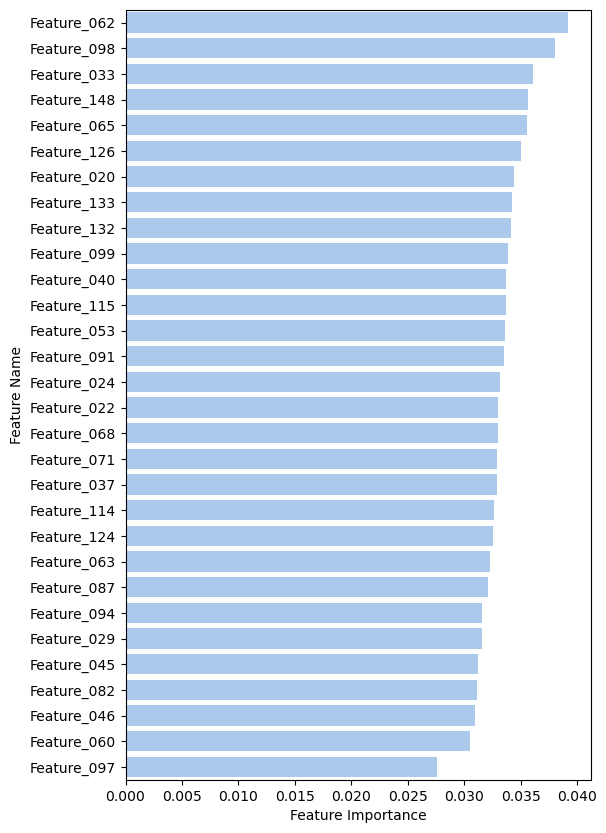

In [30]:
f,ax = plt.subplots(figsize=(6,10))

sns.set_color_codes("pastel")
sns.barplot(x="Feature Importance", y="Feature Name", data=xgb_feature_importance, orient="h", color="b")

In [31]:
pd.set_option("display.max_rows", None)
xgb_feature_importance.head()

,Feature Name,Feature Importance
11,Feature_062,0.039232
21,Feature_098,0.038017
4,Feature_033,0.036118
29,Feature_148,0.035646
13,Feature_065,0.035558


In [32]:
xgb_feature_importance.to_excel('feature_importance.xlsx')
#END